<a href="https://colab.research.google.com/github/munazzaz/-Number-Guessing-Game/blob/main/customer_support_agent_langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building an Intelligent Customer Support Agent with LangGraph

## Overview
This tutorial demonstrates how to create an intelligent customer support agent using LangGraph, a powerful tool for building complex language model workflows. The agent is designed to categorize customer queries, analyze sentiment, and provide appropriate responses or escalate issues when necessary.

## Motivation
In today's fast-paced business environment, efficient and accurate customer support is crucial. Automating the initial stages of customer interaction can significantly reduce response times and improve overall customer satisfaction. This project aims to showcase how advanced language models and graph-based workflows can be combined to create a sophisticated support system that can handle a variety of customer inquiries.

## Key Components
1. **State Management**: Using TypedDict to define and manage the state of each customer interaction.
2. **Query Categorization**: Classifying customer queries into Technical, Billing, or General categories.
3. **Sentiment Analysis**: Determining the emotional tone of customer queries.
4. **Response Generation**: Creating appropriate responses based on the query category and sentiment.
5. **Escalation Mechanism**: Automatically escalating queries with negative sentiment to human agents.
6. **Workflow Graph**: Utilizing LangGraph to create a flexible and extensible workflow.

## Method Details
1. **Initialization**: Set up the environment and import necessary libraries.
2. **State Definition**: Create a structure to hold query information, category, sentiment, and response.
3. **Node Functions**: Implement separate functions for categorization, sentiment analysis, and response generation.
4. **Graph Construction**: Use StateGraph to define the workflow, adding nodes and edges to represent the support process.
5. **Conditional Routing**: Implement logic to route queries based on their category and sentiment.
6. **Workflow Compilation**: Compile the graph into an executable application.
7. **Execution**: Process customer queries through the workflow and retrieve results.

## Conclusion
This tutorial demonstrates the power and flexibility of LangGraph in creating complex, AI-driven workflows. By combining natural language processing capabilities with a structured graph-based approach, we've created a customer support agent that can efficiently handle a wide range of queries. This system can be further extended and customized to meet specific business needs, potentially integrating with existing customer support tools and databases for even more sophisticated interactions.

The approach showcased here has broad applications beyond customer support, illustrating how language models can be effectively orchestrated to solve complex, multi-step problems in various domains.

## Import necessary libraries


In [1]:
%pip install -q -U langchain
%pip install -q -U langgraph
%pip install -q -U langchain-google-genai
%pip install -q -U python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 446.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.4/404.4 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.8

In [2]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod
from dotenv import load_dotenv
import os

# Load environment variables and set OpenAI API key


In [3]:
from google.colab import userdata

# Access the GEMINI_API_KE from Colab's Secrets
gemini_api_key = userdata.get("GEMINI_API_KEY")  # Use the correct secret name

# Verify it has been set correctly
# print("Gemini API Key set successfully:", gemini_api_key)


## Define State Structure

We define a `State` class to hold the query, category, sentiment, and response for each customer interaction.

In [4]:
class State(TypedDict):
    query: str
    category: str
    sentiment: str
    response: str



In [5]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key = gemini_api_key)

## Define Node Functions

These functions represent the different stages of processing a customer query.

In [6]:
# # # Import necessary classes
# # from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
# # from langchain.chat_models import ChatGoogleGenerativeAI

# # Initialize Gemini model
# llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=gemini_api_key)

# def categorize(state: State) -> State:
#     """Categorize the customer query into Technical, Billing, or General."""
#     prompt = ChatPromptTemplate.from_template(
#         "Categorize the following customer query into one of these categories: "
#         "Technical, Billing, General. Query: {query}"
#     )
#     chain = LLMChain(llm=llm, prompt=prompt)
#     category = chain.run({"query": state["query"]})
#     return {"category": category}

# def analyze_sentiment(state: State) -> State:
#     """Analyze the sentiment of the customer query as Positive, Neutral, or Negative."""
#     prompt = ChatPromptTemplate.from_template(
#         "Analyze the sentiment of the following customer query. "
#         "Respond with either 'Positive', 'Neutral', or 'Negative'. Query: {query}"
#     )
#     chain = LLMChain(llm=llm, prompt=prompt)
#     sentiment = chain.run({"query": state["query"]})
#     return {"sentiment": sentiment}


# def handle_technical(state: State) -> State:
#     """Provide a technical support response to the query."""
#     prompt = ChatPromptTemplate.from_template(
#         "Provide a technical support response to the following query: {query}"
#     )
#     chain = LLMChain(llm=llm, prompt=prompt)
#     response = chain.run({"query": state["query"]})
#     return {"response": response}

# def handle_billing(state: State) -> State:
#     """Provide a billing support response to the query."""
#     prompt = ChatPromptTemplate.from_template(
#         "Provide a billing support response to the following query: {query}"
#     )
#     chain = LLMChain(llm=llm, prompt=prompt)
#     response = chain.run({"query": state["query"]})
#     return {"response": response}

# def handle_general(state: State) -> State:
#     """Provide a general support response to the query."""
#     prompt = ChatPromptTemplate.from_template(
#         "Provide a general support response to the following query: {query}"
#     )
#     chain = LLMChain(llm=llm, prompt=prompt)
#     response = chain.run({"query": state["query"]})
#     return {"response": response}

# def escalate(state: State) -> State:
#     """Escalate the query to a human agent due to negative sentiment."""
#     return {"response": "This query has been escalated to a human agent due to its negative sentiment."}

# def route_query(state: State) -> str:
#     """Route the query based on its sentiment and category."""
#     if state["sentiment"] == "Negative":
#         return "escalate"
#     elif state["category"] == "Technical":
#         return "handle_technical"
#     elif state["category"] == "Billing":
#         return "handle_billing"
#     else:
#         return "handle_general"

def categorize(state: State) -> State:
    """Categorize the customer query into Technical, Billing, General, Shipping and Delivery, or Sales and Promotions."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories: "
        "Technical, Billing, General, Shipping and Delivery, Sales and Promotions. "
        "Ensure to consider all keywords related to sales, discounts, or promotions. "
        "Query: {query}"
    )
    chain = LLMChain(llm=llm, prompt=prompt)
    category = chain.run({"query": state["query"]})
    return {"category": category}


def analyze_sentiment(state: State) -> State:
    """Analyze the sentiment of the customer query as Positive, Neutral, or Negative."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer query. "
        "Respond with either 'Positive', 'Neutral', or 'Negative'. Query: {query}"
    )
    chain = LLMChain(llm=llm, prompt=prompt)
    sentiment = chain.run({"query": state["query"]})
    return {"sentiment": sentiment}

def handle_technical(state: State) -> State:
    """Provide a technical support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a technical support response to the following query: {query}"
    )
    chain = LLMChain(llm=llm, prompt=prompt)
    response = chain.run({"query": state["query"]})
    return {"response": response}

def handle_billing(state: State) -> State:
    """Provide a billing support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a billing support response to the following query: {query}"
    )
    chain = LLMChain(llm=llm, prompt=prompt)
    response = chain.run({"query": state["query"]})
    return {"response": response}

def handle_general(state: State) -> State:
    """Provide a general support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a general support response to the following query: {query}"
    )
    chain = LLMChain(llm=llm, prompt=prompt)
    response = chain.run({"query": state["query"]})
    return {"response": response}

def handle_shipping(state: State) -> State:
    """Provide a shipping and delivery response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a shipping and delivery support response to the following query: {query}"
    )
    chain = LLMChain(llm=llm, prompt=prompt)
    response = chain.run({"query": state["query"]})
    return {"response": response}

def handle_sales(state: State) -> State:
    """Provide a sales and promotions response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a sales and promotions response to the following query: {query}"
    )
    chain = LLMChain(llm=llm, prompt=prompt)
    response = chain.run({"query": state["query"]})
    return {"response": response}

def escalate(state: State) -> State:
    """Escalate the query to a human agent due to negative sentiment."""
    return {"response": "This query has been escalated to a human agent due to its negative sentiment."}

def route_query(state: State) -> str:
    """Route the query based on its sentiment and category."""
    if state["sentiment"] == "Negative":
        return "escalate"
    elif state["category"] == "Technical":
        return "handle_technical"
    elif state["category"] == "Billing":
        return "handle_billing"
    elif state["category"] == "Shipping and Delivery":
        return "handle_shipping"
    elif state["category"] == "Sales and Promotions":
        return "handle_sales"  # Route to sales handling
    else:
        return "handle_general"


## Create and Configure the Graph

Here we set up the LangGraph, defining nodes and edges to create our customer support workflow.

In [7]:
# # Create the graph
# workflow = StateGraph(State)

# # Add nodes
# workflow.add_node("categorize", categorize)
# workflow.add_node("analyze_sentiment", analyze_sentiment)
# workflow.add_node("handle_technical", handle_technical)
# workflow.add_node("handle_billing", handle_billing)
# workflow.add_node("handle_general", handle_general)
# # workflow.add_node("handle_coding", handle_coding)
# workflow.add_node("escalate", escalate)

# # Add edges
# workflow.add_edge("categorize", "analyze_sentiment")
# workflow.add_conditional_edges(
#     "analyze_sentiment",
#     route_query,
#     {
#         "handle_technical": "handle_technical",
#         "handle_billing": "handle_billing",
#         "handle_general": "handle_general",
#         "escalate": "escalate",

#     }
# )
# workflow.add_edge("handle_technical", END)
# workflow.add_edge("handle_billing", END)
# workflow.add_edge("handle_general", END)
# workflow.add_edge("escalate", END)


# # Set entry point
# workflow.set_entry_point("categorize")

# # Compile the graph
# app = workflow.compile()

workflow = StateGraph(State)

# Add nodes
workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("handle_shipping", handle_shipping)  # Node for shipping inquiries
workflow.add_node("handle_sales", handle_sales)  # New node for sales inquiries
workflow.add_node("escalate", escalate)

# Add edges
workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query,
    {
        "handle_technical": "handle_technical",
        "handle_billing": "handle_billing",
        "handle_general": "handle_general",
        "handle_shipping": "handle_shipping",  # Connect shipping handling
        "handle_sales": "handle_sales",  # Connect sales handling
        "escalate": "escalate",
    }
)
workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("handle_shipping", END)  # Connect shipping handling to the end
workflow.add_edge("handle_sales", END)  # Connect sales handling to the end
workflow.add_edge("escalate", END)

# Set entry point
workflow.set_entry_point("categorize")

# Compile the graph
app = workflow.compile()



## Visualize the Graph

This cell generates and displays a visual representation of our LangGraph workflow.

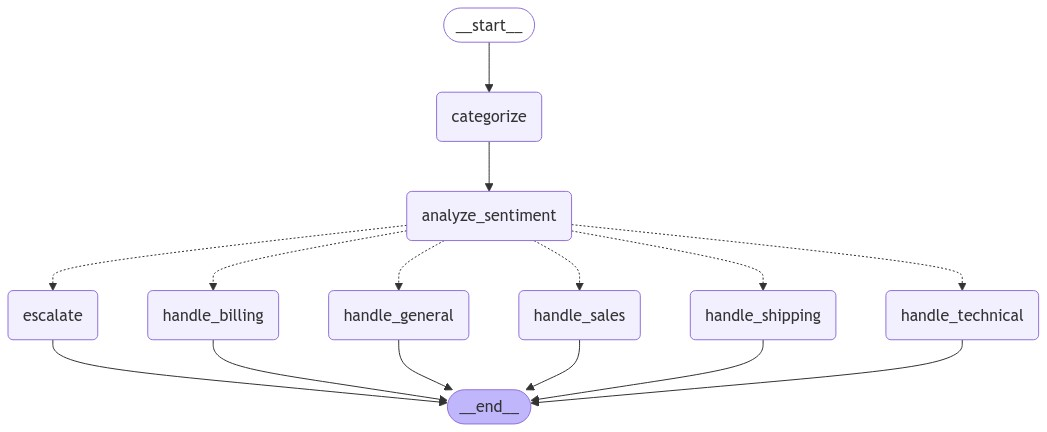

In [8]:
# Visualize the graph
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Run Customer Support Function

This function processes a customer query through our LangGraph workflow.

In [9]:
def run_customer_support(query: str) -> Dict[str, str]:
    """Process a customer query through the LangGraph workflow.

    Args:
        query (str): The customer's query

    Returns:
        Dict[str, str]: A dictionary containing the query's category, sentiment, and response
    """
    results = app.invoke({"query": query})
    return {
        "category": results["category"],
        "sentiment": results["sentiment"],
        "response": results["response"]
    }


## Test the Customer Support Agent

Let's test our customer support agent with a sample queries for each kind of query type.

In [10]:
# # escalate

# query = "My internet connection keeps dropping. Can you help?"
# result = run_customer_support(query)
# print(f"Query: {query}")
# print(f"Category: {result['category']}")
# print(f"Sentiment: {result['sentiment']}")
# print(f"Response: {result['response']}")
# print("\n")

query = "My internet connection keeps dropping. Can you help?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

query = "Where is my order? It was supposed to arrive yesterday!"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")


# query = "¿Cómo puedo acceder a mi recibo?"
# result = run_customer_support(query)
# print(f"Query: {query}")
# print(f"Category: {result['category']}")
# print(f"Sentiment: {result['sentiment']}")
# print(f"Response: {result['response']}")
# print("\n")

# handle_billing

query = "where can i find my receipt?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

# handle_general

query = "What are your business hours?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

query = "How do I fix a TypeError in Python?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

query = "Are there any ongoing promotions or discounts?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")




<ipython-input-6-a2815e6c1b76>:80: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(llm=llm, prompt=prompt)
<ipython-input-6-a2815e6c1b76>:81: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  category = chain.run({"query": state["query"]})


Query: My internet connection keeps dropping. Can you help?
Category: **Technical** 

This query focuses on a problem with the internet connection, which falls under technical support. 

Sentiment: Negative 

Response: I understand your frustration with a constantly dropping internet connection. To help me pinpoint the issue, could you please tell me a little more about what's happening? For example:

* **How often does your connection drop?** (e.g., every few minutes, a few times a day, etc.)
* **How long does the connection drop last?** (e.g., a few seconds, a few minutes, etc.)
* **What happens when the connection drops?** (e.g., complete internet outage, slow speeds, websites not loading, etc.)
* **Are you using a wired or wireless connection?**
* **Have you made any recent changes to your network or devices?**

The more details you can provide, the better I can understand the problem and offer helpful suggestions. 



Query: Where is my order? It was supposed to arrive yesterday!


Query: Are there any ongoing promotions or discounts?
Category: **Sales and Promotions** 

This query directly asks about promotions and discounts, which are clearly related to sales and promotions. 

Sentiment: Neutral 

Response: We do have ongoing promotions and discounts! To get the most up-to-date information, I recommend checking our website [link to website] or contacting our customer service team at [phone number or email address]. They'll be happy to help you find the best deals available. 

